In [1]:
"""
import sys
import os

parent=os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.append(parent)
"""

import main

/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---------------------------
PATHS
---------------------------
local: /home/lachlan/CODEBASE/ReadoutXFM
data: /home/lachlan/CODEBASE/ReadoutXFM/data/example_datafile.GeoPIXE
output: /home/lachlan/CODEBASE/ReadoutXFM/data/out_example_datafile
---------------------------
---------------------------
header length: 1162 (bytes)
--------------
INDEXING
Row 70/70 at pixel 12249, byte 88726796 (100.0 %)
END OF MAP: row 70/70, pixel 12249
--------------
PARSING PIXEL DATA
Row 70/70 at pixel 12249, byte 88722712 (100.0 %)
END OF MAP: row 70/70, pixel 12249
---------------------------
COMPLETE
---------------------------
dimensions expected (x,y): 175,70
pixels expected (X*Y): 12250
pixels found: 12250
total time: 16.04 s
time per pixel: 0.001309 s
---------------------------
fitting baselines
rgb maxima: r 2110057.9446722856 g 2106179.7971838824 b 14650.099949220114
scaled maxima: r 1.0 g 0.9981620658815579 b 0.006942984663625164
Processing complete


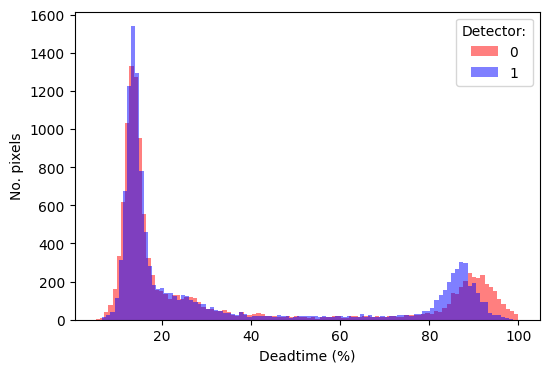

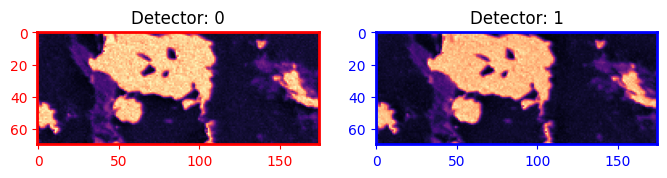

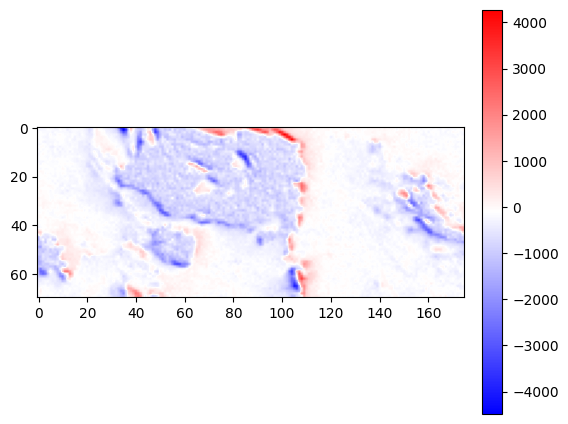

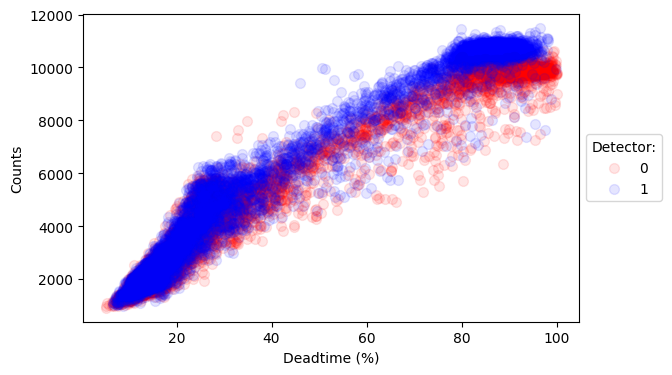

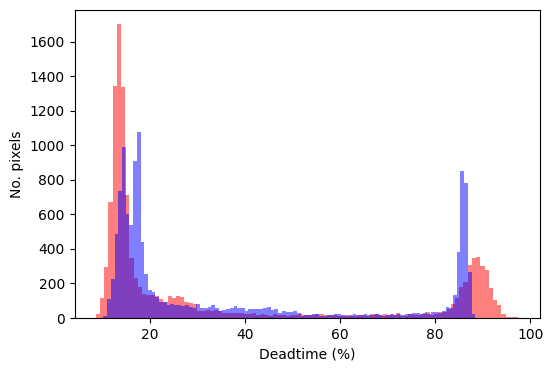

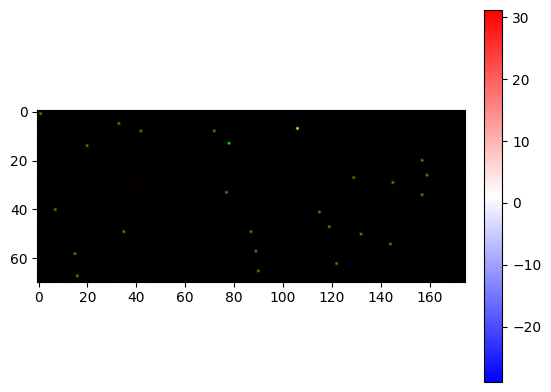

In [2]:
args_in = ["-f", "data/example_datafile.GeoPIXE", "-a", ] 

pixelseries, xfmap = main.main(args_in)

In [3]:
import os
import sys
import numpy as np
import scipy as sp
import pybaselines.smooth
import matplotlib.pyplot as plt

#-----------------------------------
#MODIFIABLE CONSTANTS
#-----------------------------------

SNIPWINDOW=50   #width-window for SNIP algorithm - 50 is default
LOWCUT=80       #low cut point for SNIP

YIELD_LINES=np.array([ 0.5  ,  1.   ,  1.486,  1.739,  2.013,  2.304,  2.957,  3.312, \
        3.69 ,  4.508,  5.411,  5.894,  6.398,  6.924,  7.471,  8.04 , \
       10.53 , 11.907, 13.373, 14.14 , 15.744, 17.441, 25.   ])


YIELD_FACTORS=np.array([5.00000e-04, 3.00000e-05, 1.20000e-05, 1.75000e-05, 2.07492e-05, \
       3.66851e-05, 4.05230e-05, 5.59011e-05, 6.93785e-05, 1.75159e-04, \
       3.61108e-04, 4.65544e-04, 6.04780e-04, 6.97253e-04, 5.42119e-04, \
       5.58549e-04, 5.01282e-04, 4.43092e-04, 3.77418e-04, 3.68455e-04, \
       2.00000e-04, 1.50000e-04, 1.00000e-04])


#-----------------------------------
#INITIALISE
#-----------------------------------

this = sys.modules[__name__]

#-----------------------------------
#FUNCTIONS
#-----------------------------------


def plotspline(CORRECTION_FACTORS, energy, yield_lines, yield_inverted):
    fig, ax1 = plt.subplots() 

    ax1.set_xlabel('energy (kV)') 
    ax1.set_ylabel('Intensity') 
    ax1.axis(xmin=0,xmax=30)

    ax1.set_yscale('log')
    #ax1.axis(ymin=0.00005,ymax=1)

    ax1.plot(energy, CORRECTION_FACTORS, "r+" )

    ax1.plot(yield_lines, yield_inverted, "ko")

    plt.show()


def plotcorrection(spectrum, energy, bg, sub, adj):

    #return adj

    fig, ax1 = plt.subplots() 

    ax1.set_xlabel('energy (kV)') 
    ax1.set_ylabel('Intensity') 
    ax1.axis(xmin=0,xmax=30)

    #ax1.set_yscale('log')
    #ax1.axis(ymin=0.8,ymax=10000000)

    ax1.plot(energy, spectrum, color="grey")
    ax1.plot(energy, bg, color="red")
    ax1.plot(energy, sub, color="blue")
    ax1.plot(energy, adj, color="green")



def initialise(energy):

    yield_inverted=1/YIELD_FACTORS

    spline = sp.interpolate.UnivariateSpline(YIELD_LINES, yield_inverted, k=1)

    CORRECTION_FACTORS = spline(energy)

    if False:
        plotspline(CORRECTION_FACTORS, energy, yield_lines, yield_inverted)

    return CORRECTION_FACTORS


def correct_spec(spectrum, CORRECTION_FACTORS):
    spectrum=spectrum

    bg = pybaselines.smooth.snip(spectrum, 30, decreasing=True, smooth_half_window=1)[0]

    sub = spectrum-bg

    #set all values <1 to 0 so they don't get scaled by the multiplier
    sub[sub < 1] = 0

    adj=sub*CORRECTION_FACTORS

    if False:
        plotcorrection(spectrum, energy, bg, sub, adj)      #energy not in local namespace otherwise

    return adj    


def calc_corrected(dataset, energy, npx, nchan):

    print("fitting baselines")

    CORRECTION_FACTORS = initialise(energy)

    corrected=np.zeros((npx,nchan),dtype=np.uint16)

    for i in np.arange(npx):
        corrected[i]=correct_spec(dataset[i], CORRECTION_FACTORS)

    return corrected

In [4]:
import matplotlib.pyplot as plt

def plotspec(spectrum, energy):

    fig, ax1 = plt.subplots() 

    ax1.set_xlabel('energy (kV)') 
    ax1.set_ylabel('Intensity') 
    ax1.axis(xmin=0,xmax=30)

    ax1.set_yscale('log')

    ax1.plot(energy, spectrum, color="grey")
    
    ax1.set_ylim(bottom=0.1)
    

array([1, 1, 1, ..., 1, 1, 1], dtype=uint32)

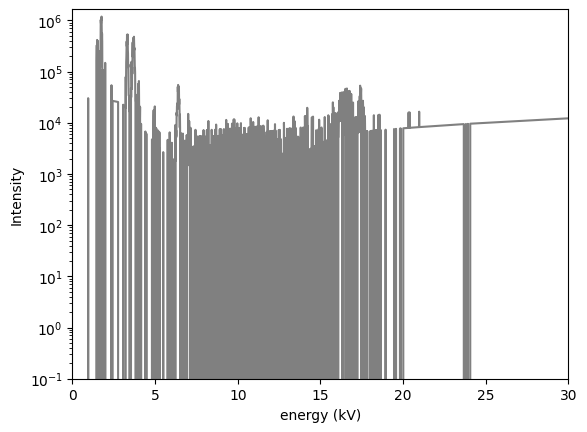

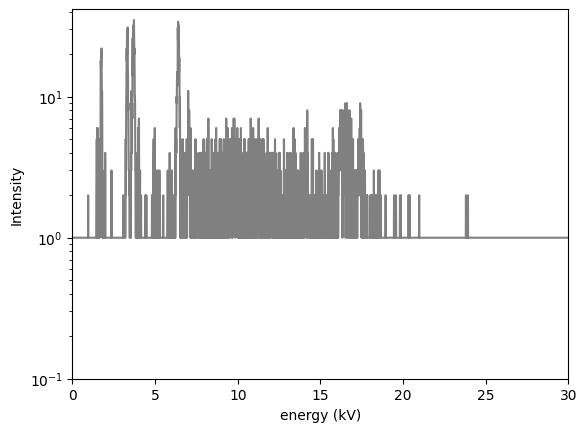

In [15]:
import numpy as np
np.max(pixelseries.data[0,:])

import xfmreadout.clustering as clustering

#plotspec(pixelseries.classavg[0,1], pixelseries.energy)

plotspec(pixelseries.corrected[1], pixelseries.energy)
plotspec(pixelseries.flattened[1], pixelseries.energy)

pixelseries.flattened[1]

dtype('uint32')

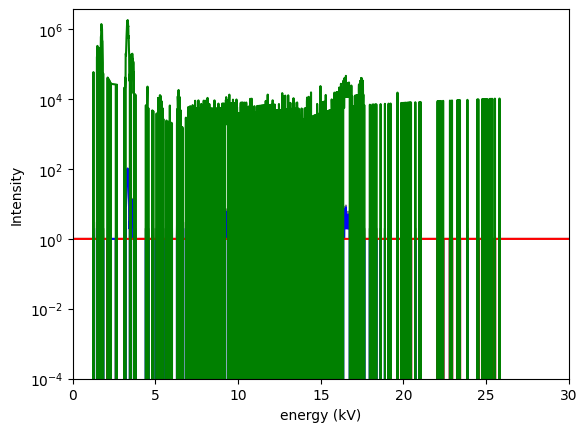

In [11]:
import pybaselines.smooth

CORRECTION_FACTORS = initialise(pixelseries.energy)

#testcorr=correct_spec(pixelseries.classavg[0,1], CORRECTION_FACTORS)

energy=pixelseries.energy
#spectrum=pixelseries.classavg[0,1]
spectrum=pixelseries.flattened[500]
spectrum[spectrum<1]=1

bg = pybaselines.smooth.snip(spectrum, 30, decreasing=True, smooth_half_window=1)[0]
bg=bg.astype(np.uint32)
sub = spectrum-bg

#set all values <1 to 0 so they don't get scaled by the multiplier
#sub[sub < 1] = 0

adj=sub*CORRECTION_FACTORS

#adj[adj<0.001]=0

adj=adj.astype(np.uint32)

fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=30)

ax1.set_yscale('log')

ax1.plot(energy, spectrum, color="grey")
ax1.plot(energy, sub, color="blue")
ax1.plot(energy, bg, color="red")
ax1.plot(energy, adj, color="green")

ax1.set_ylim(bottom=0.0001)

#adj.astype(np.uint32

adj.dtype

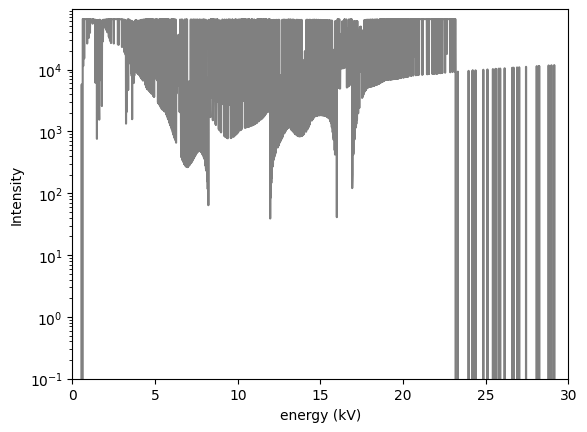

str

In [4]:

cdict = {'red':   [[0.0,  1.0, 1.0],
                   [0.143,  1.0, 1.0],
                   [0.286,  1.0, 1.0],
                   [0.429,  0.0, 0.0],
                   [0.571,  0.0, 0.0],
                   [0.714,  0.0, 0.0],
                   [0.857,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],

         'green': [[0.0,  0.0, 0.0],
                   [0.143,  0.0, 0.0],
                   [0.286,  1.0, 1.0],
                   [0.429,  1.0, 1.0],
                   [0.571,  1.0, 1.0],
                   [0.714,  0.0, 0.0],
                   [0.857,  0.0, 0.0],
                   [1.0,  1.0, 1.0]],
                   
         'blue':  [[0.0,  1.0, 1.0],
                   [0.143,  0.0, 0.0],
                   [0.286,  0.0, 0.0],
                   [0.429,  0.0, 0.0],
                   [0.571,  1.0, 1.0],
                   [0.714,  1.0, 1.0],
                   [0.857,  1.0, 1.0],
                   [1.0,  1.0, 1.0]]}

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

chan_lo=100
chan_high=1750
high_pad=pixelseries.nchan-chan_high
lo_pad=chan_lo

energy=pixelseries.energy
#spectrum=pixelseries.classavg[1,1]
spectrum=pixelseries.corrected[500]
spectrum=spectrum/max(spectrum)

cmp = matplotlib.colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=chan_high)

cred=np.zeros(pixelseries.nchan)
cgreen=np.zeros(pixelseries.nchan)
cred=np.zeros(pixelseries.nchan)

rgba = cmp(np.linspace(0, 1, chan_high-chan_lo))

#print('colarray',rgba[0,:3])    #index starts from 1 instead of 0, not sure why

cred=rgba[:,0]
cgreen=rgba[:,1]
cblue=rgba[:,2]

print(cred.shape)

cred=np.pad(cred, (lo_pad, high_pad), mode='constant', constant_values=(1, 1))
cgreen=np.pad(cgreen, (lo_pad, high_pad), mode='constant', constant_values=(0, 1))
cblue=np.pad(cblue, (lo_pad, high_pad), mode='constant', constant_values=(1, 1))

print(cred.shape)

(1650,)
(4096,)


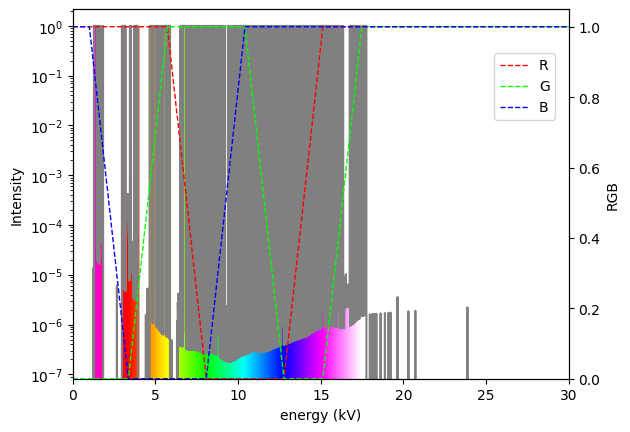

In [12]:
fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=30)
ax1.set_yscale('log')
#ax1.axis(ymin=vymin,ymax=1)
#ax1.axis(ymin=0.00005,ymax=1)

ax2 = ax1.twinx() 
ax2.set_ylabel('RGB')
ax2.axis(ymin=0,ymax=1.05)

ax2.plot(energy, cred, '#ff0000', linestyle='dashed', linewidth=1, label="R")
ax2.plot(energy, cgreen, '#00ff00', linestyle='dashed', linewidth=1, label="G")
ax2.plot(energy, cblue, '#0000ff', linestyle='dashed', linewidth=1, label="B")

ax2.legend(loc=(0.85,0.7))

ax1.plot(energy, spectrum, color="gray")
for i in range(len(spectrum) - 1):
    ax1.fill_between([energy[i], energy[i+1]], [spectrum[i], spectrum[i+1]], y2=-1, color=(cred[i],cgreen[i],cblue[i]))


#plt.savefig(os.path.join(odir, 'hsv_spectrum.png'), dpi=150)
plt.show()